In [1]:
# Imports & Initializations.
%load_ext autoreload
%autoreload 2
import csv
import itertools
import json
import os
import pickle
import sys
import time
from pathlib import Path
from scipy.stats import spearmanr

import comet_ml
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from aim import Repo
from naapc import NDict
from tqdm import tqdm

from query_configs import cifar_normal, cifar_normal_numes
from stracker.ana import get_metric_value_of_aim_run, get_repeated_missing_seeds, query, get_metric_names_of_aim_run, filt_aim_repeated_runs

check_repeat_ops = {
    "delete_repeat": False,
    "archive_repeat": False,
}

result_path = Path() / "results"
result_path.mkdir(exist_ok=True, parents=True)
aim_path = Path("/Users/ei/Documents/aim/crowdsourcing")
repo = Repo(str(aim_path))
run = next(repo.iter_runs())
hash_hparams = {run.hash: NDict(run["hparams"]) for run in repo.iter_runs()}


In [ ]:
# Check for cifar olrandom.
task = "olrandom"
filt_option = "latest"
check_repeat_ops["archive_repeat"] = False
seeds = [1, 2, 3, 4, 5]
trainer_configs = cifar_normal
splits = [10, 50, 100]
saving_hashes = {split: {} for split in splits}
for (tr, config), split in itertools.product(trainer_configs.items(), splits):
    if tr in ["ft", "lwf"]:
        continue
    config["data;split"] = split
    config["task;task"] = task
    config["train;plateau_metric"] = "QUERY v in ['acc', 'train_acc']"
    config["task;seed"] = f"QUERY v in {seeds}"

    prefix_info = f"cifar:olrandom-split{split}-{tr} "
    metas = query(hash_hparams, config, missing_path_action="ignore")
    repetitions, missing = get_repeated_missing_seeds(metas, "task;seed", seeds, verbose=True, prefix=prefix_info)
    runs = [repo.get_run(h) for h in metas.keys()]
    if repetitions:
        repetitions = {s: [repo.get(h) for h in hashes] for s, hashes in repetitions.items()}
    runs = filt_aim_repeated_runs(runs, repetitions)
    saving_hashes[split][tr] = [run.hash for run in runs]

with open(result_path / "cifar-olrandom-hash.yaml", "w") as f:
    yaml.dump(saving_hashes, f)


10 eeil
10 eeol
10 icarl
10 lucir
10 lucir_cwd
10 podnet
50 eeil
50 eeol
50 icarl
50 lucir
50 lucir_cwd
50 podnet
100 eeil
100 eeol
100 icarl
100 lucir
100 lucir_cwd
100 podnet


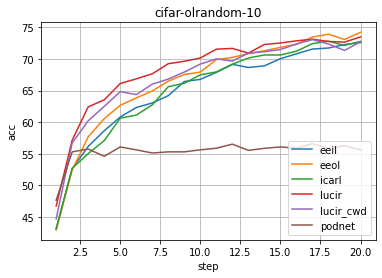

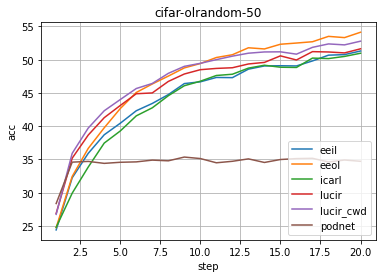

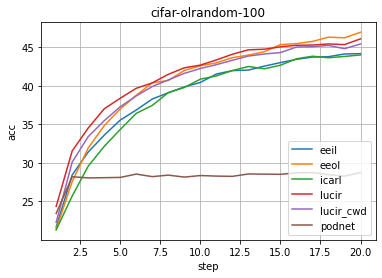

In [4]:
# Cifar olrandom test_batch_acc
with open(result_path / "cifar-olrandom-hash.yaml", "r") as f:
    keys = yaml.safe_load(f)

splits = [10, 50, 100]
seeds = [1, 2, 3, 4, 5]
gen_results = True
if gen_results:
    results = {split: {} for split in splits}
    for split, shashes in keys.items():
        for tr, hs in shashes.items():
            print(split, tr)
            runs = [repo.get_run(h) for h in hs]
            run_seeds = {NDict(run["hparams"])["task;seed"] for run in runs}
            assert run_seeds == set(seeds), run_seeds
            # print(split, tr, hs, get_metric_value_of_aim_run(runs[0], "test_batch_acc"))
            metrics = np.concatenate(
                [np.array(get_metric_value_of_aim_run(run, "test_batch_acc")).reshape(1, -1) for run in runs], axis=0
            )
            assert metrics.shape[0] == len(seeds)
            mean_metrics = metrics.mean(axis=0)
            all_metrics = {
                "batch": mean_metrics.tolist(),
                "inc": mean_metrics.mean().item(),
                "fin": mean_metrics[-1].item(),
                "spearmanc": spearmanr(
                    mean_metrics, list(range(mean_metrics.size))
                ).correlation.item(),
                "spearmanp": spearmanr(
                    mean_metrics, list(range(mean_metrics.size))
                ).pvalue.item(),
            }
            results[split][tr] = all_metrics
    with open(result_path / "cifar-olrandom-metrics.yaml", "w") as f:
        yaml.dump(results, f)
else:
    with open(result_path / "cifar-olrandom-metrics.yaml", "r") as f:
        results = yaml.safe_load(f)

for split, sms in results.items():
    # plot_metrics({tr: m["batch"] for tr, m in sms.items()}, f"cifar-olrandom-{split}", "step", "acc")
    plt.figure()
    plt.title(f"cifar-olrandom-{split}")
    plt.xlabel("step")
    plt.ylabel("acc")
    metrics = {tr: m["batch"] for tr, m in sms.items()}
    for k, ms in metrics.items():
        step = list(range(1, len(ms) + 1))
        plt.plot(step, ms, label=k)
    plt.legend()
    plt.grid()


In [ ]:
# Check for cifar num_e.
pro.update_dbs()
check_repeat_ops["archive_repeat"] = False

task = "olrandom"
seeds = [1, 2, 3, 4, 5]

task = "olrandom"
check_repeat_ops["archive_repeat"] = False
seeds = [1, 2, 3, 4, 5]
splits = cifar_splits["olrandom"]
splits = [10]
config = cifar_normal["eeol"]
config["data;split"] = 10
config["log;note"] = "small_dist0.5"
config["task;task"] = "olrandom"
saving_keys = {}

num_es = [x * 10 for x in range(1, 21)]

saving_keys = {}
# for p, smooth, losst, suppress in itertools.product(prompts, smooths, lossts, suppresses):
cnt = 0
for num_e in num_es:
    config["train;plateau_metric"] = lambda v, config: v in ["acc", "train_acc"]
    config["task;num_exemplars_per_class"] = num_e

    prefix_info = f"cifar:{task}-num_e{num_e}"
    keys, repeated, missing = deal_seeds(pro, config, prefix_info, seeds, check_repeat_ops, True)

    if len(missing) == 0:
        saving_keys[num_e] = list(keys)
    else:
        cnt += len(missing)
print(f"Missing {cnt} in total.")
# saving_keys["configs"] = config
with open(result_path / "cifar-olrandom-eeol-num_e-keys.yaml", "w") as f:
    yaml.dump(saving_keys, f)

In [ ]:
# Cifar num_e test_batch_acc
# pro.update_dbs()
with open(result_path / "cifar-olrandom-eeol-num_e-keys.yaml", "r") as f:
    keys = yaml.safe_load(f)

# splits = cifar_splits["olrandom"]
seeds = [1, 2, 3, 4, 5]
gen_results = True
if gen_results:
    results = {}
    for num_e, ks in keys.items():
        exps = [pro.get(k) for k in ks]
        results[num_e] = get_metrics(exps, seeds)
    with open(result_path / "cifar-olrandom-eeol-num_e-result.csv", "w") as f:
        heads = ",".join([f"num_e{num_e}" for num_e in keys.keys()] + [f"num_e{num_e}_fin" for num_e in keys.keys()] + [f"num_e{num_e}_inc" for num_e in keys.keys()]) + "\n"
        f.write(heads)
        for i in range(20):
            tmp = [str(results[num_e]["batch"][i]) for num_e in results]
            if i == 0:
                tmp += [str(results[num_e]["fin"]) for num_e in results]
                tmp += [str(results[num_e]["inc"]) for num_e in results]
            f.write(",".join(tmp) + "\n")
    with open(result_path / "cifar-olrandom-eeol-num_e-result.yaml", "w") as f:
        yaml.dump(results, f)
else:
    with open(result_path / "cifar-olrandom-eeol-num_e-result.yaml", "r") as f:
        results = yaml.safe_load(f)

fins = sorted([[num_e, m["fin"]] for num_e, m in results.items()], key=lambda x: x[0])
incs = sorted([[num_e, m["inc"]] for num_e, m in results.items()], key=lambda x: x[0])

plt.figure()
num_e, fin = zip(*fins)
plt.plot(num_e, fin, label="final")
num_e, inc = zip(*incs)
plt.plot(num_e, inc, label="incremental")
plt.legend()
plt.grid()
plt.show()
